In [1]:
import os
import shutil
import random
#Cargar categorias y dividir el dataset
splitsize = .7
categories = []
source = "/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/"
folders = os.listdir(source)
if ".DS_Store" in folders:
    os.remove(f"{source}/.DS_store")

for subfolder in folders:
    if os.path.isdir(source + subfolder):
        categories.append(subfolder)
categories.sort()
print(categories)

#Create dataset
target_folder = "/Users/cristiansandoval/Universidad/Herramientas/CNN/dataset"
existDatasetPath = os.path.exists(target_folder)
if not existDatasetPath:
    os.mkdir(target_folder)

#split data train and test
def split_data(SOURCE, TRAINING, TEST, SPLIT_SIZE):
    files = []

    for filename in os.listdir(SOURCE):
        file = SOURCE + "/" +filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is empty")
    print(len(files))
    print(SPLIT_SIZE)
    trainingLength = round(len(files) * SPLIT_SIZE)
    shuffleSet = random.sample(files, len(files))
    trainingSet = shuffleSet[0:trainingLength]
    testSet = shuffleSet[trainingLength:]

    #copy train images
    for filename in trainingSet:
         thisFile = SOURCE + filename
         destination = TRAINING + filename
         shutil.copyfile(thisFile, destination)
    
    #copy test images
    for filename in testSet:
        thisFile = SOURCE + filename
        destination = TEST + filename
        shutil.copyfile(thisFile, destination)

trainPath = target_folder + "/train"
testPath = target_folder + "/test"

#create target folders
existTrainPath = os.path.exists(trainPath)
if not existTrainPath:
    os.mkdir(trainPath)

existTestPath = os.path.exists(testPath)
if not existTestPath:
    os.mkdir(testPath)

for category in categories:
    trainDestPath = trainPath + "/" + category
    testDestPath = testPath + "/" + category

    if not os.path.exists(trainDestPath):
        os.mkdir(trainDestPath)
    if not os.path.exists(testDestPath):
        os.mkdir(testDestPath)

    sourcePath = source + category + "/"
    trainDestPath = trainDestPath + "/" 
    testDestPath = testDestPath + "/"

    print("Copy from: " + sourcePath + " to: " + trainDestPath + " " + testDestPath)
    split_data(sourcePath, trainDestPath, testDestPath, splitsize)
    

['anartia_amathea', 'heliconius_doris', 'melanis_electron']
Copy from: /Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/anartia_amathea/ to: /Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/train/anartia_amathea/ /Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/test/anartia_amathea/
102
0.7
Copy from: /Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/heliconius_doris/ to: /Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/train/heliconius_doris/ /Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/test/heliconius_doris/
76
0.7
Copy from: /Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/melanis_electron/ to: /Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/train/melanis_electron/ /Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/test/melanis_electron/
76
0.7


Found 247 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


/opt/anaconda3/envs/herramientas/lib/python3.9/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
/opt/anaconda3/envs/herramientas/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.3959 - loss: 1.1029

/opt/anaconda3/envs/herramientas/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4104 - loss: 1.0855 - val_accuracy: 0.7208 - val_loss: 0.6517
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7876 - loss: 0.5737 - val_accuracy: 0.7708 - val_loss: 0.5355
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7982 - loss: 0.4637 - val_accuracy: 0.8292 - val_loss: 0.3820
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8293 - loss: 0.3683 - val_accuracy: 0.8625 - val_loss: 0.3594
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8761 - loss: 0.3343 - val_accuracy: 0.8833 - val_loss: 0.2821
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9020 - loss: 0.2600 - val_accuracy: 0.8625 - val_loss: 0.3003
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8596 - loss: 0.2974 - val_accuracy: 0.8833 - val_loss: 0.2638
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8848 - loss: 0.2519 - val_accuracy: 0.8708 - val_loss: 0.2865
Epoch 9/10
8/8 ━━━━━━━━━━━

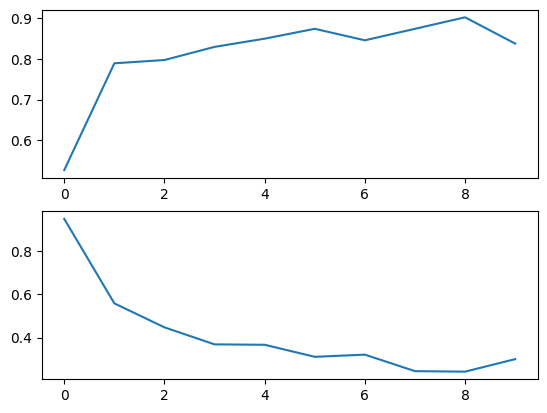

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

trainPath = "/Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/train"
testPath = "/Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/test"

#Generate more images
trainGenerator = ImageDataGenerator(rotation_range=15, width_shift_range=0.4, height_shift_range=0.1, brightness_range=(0,0.2)).flow_from_directory(trainPath, target_size=(320,320), batch_size=32)
testGenerator = ImageDataGenerator(rotation_range=15, width_shift_range=0.4, height_shift_range=0.1, brightness_range=(0,0.2)).flow_from_directory(testPath, target_size=(320,320), batch_size=32)

#Build model

baseModel = MobileNetV3Small(weights="imagenet", include_top=False)
x= baseModel.output
x= GlobalAveragePooling2D()(x) #1
x= Dense(512, activation="relu")(x) #2
x= Dense(256, activation="relu")(x) #3
x= Dense(128, activation="relu")(x) #4

predictionLayer = Dense(len(categories), activation="softmax")(x) #5

model = Model(inputs=baseModel.input, outputs=predictionLayer)

#Congelar todas las capas del modelo menos las 5 añadidas por nosotros
#Deja fijos los pesos de MobileNetV3 pero permite modificar los pesos de las capas que creamos
for layer in model.layers[:-5]:
    layer.trainable = False

#Compilar modelo
optimizer = Adam(learning_rate = 0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

#Entrenar modelo
modelTrainData = model.fit(trainGenerator, validation_data=testGenerator, epochs=10)

#Guardar modelo
saveModelPath = "/Users/cristiansandoval/Universidad/Herramientas/CNN/dataset/ModelV3.h5"
model.save(saveModelPath)

plt.figure()
plt.subplot(211)
plt.plot(modelTrainData.history['accuracy'])
plt.subplot(212)
plt.plot(modelTrainData.history['loss'])

In [3]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

#Predict Image
def classify_image(IMG_PATH):
    x=[]
    img = Image.open(IMG_PATH)
    img.load()
    img = img.resize((320,320), Image.LANCZOS)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    return pred[0]

In [4]:
img_paths = [
    "/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/melanis_electron/_8060558-melanissmithiaesmith-spixie-melanispixe4406.jpg",
    "/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/heliconius_doris/Heliconius_doris_03.jpg",
    "/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/anartia_amathea/Anartia amathea roeselia_mariposa174_NaturalezaMisiones.jpg",
    "/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/heliconius_doris/Heleconius-doris-Yellow-form-TS-Peru_001-scaled-600x600.jpg",
    "/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/anartia_amathea/Anartia_amathea_(5).jpg",
    "/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/melanis_electron/50567919412_96679cea6a_b.jpg",
]

predictions = []
for path in img_paths:
    print(path)
    predictions.append(classify_image(path))

/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/melanis_electron/_8060558-melanissmithiaesmith-spixie-melanispixe4406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/heliconius_doris/Heliconius_doris_03.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/anartia_amathea/Anartia amathea roeselia_mariposa174_NaturalezaMisiones.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/heliconius_doris/Heleconius-doris-Yellow-form-TS-Peru_001-scaled-600x600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/anartia_amathea/Anartia_amathea_(5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
/Users/cristiansandoval/Universidad/Herramientas/CNN/Insectos/melanis_electron/50567919412_96679cea6a_b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


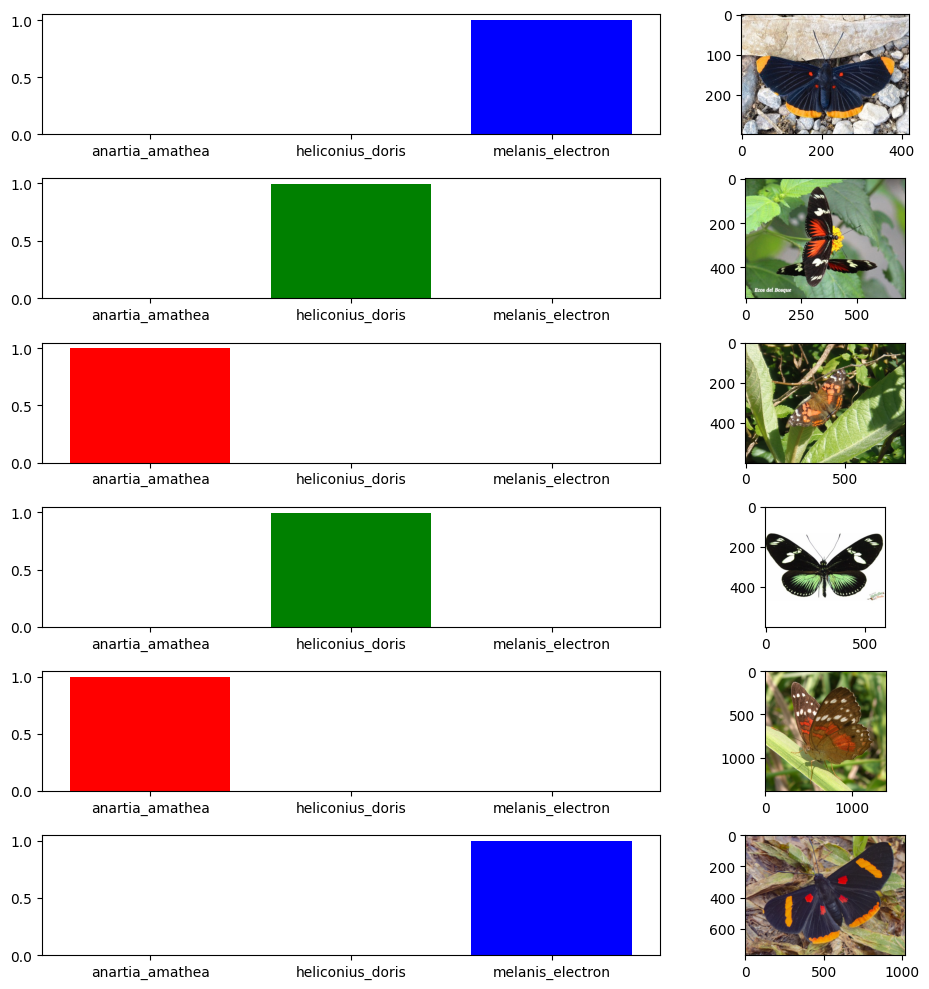

In [5]:
fig,axs = plt.subplots(len(predictions), 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})

plotIndex = 1
for i, pred in enumerate(predictions):
    plt.subplot(len(predictions), 2, plotIndex)
    plt.bar(categories, pred, color=['red', 'green', 'blue'])

    plt.subplot(len(predictions), 2, plotIndex+1)
    img = plt.imread(img_paths[i])
    plt.imshow(img)
    plotIndex += 2

fig.tight_layout()
plt.show()